In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession


from pyspark.sql.types import StringType, IntegerType, ArrayType, FloatType
from pyspark.sql.functions import udf, dense_rank, desc, asc, lit
from pyspark.sql import functions as F
from pyspark.sql.functions import collect_set
from pyspark.sql.window import Window

import math
import numpy as np
import sys


import seaborn as sns
sns.set()

# method that print only blanks
def print_blanks(n=10):
    for i in range(n):
        print('\n')

# method that create connection with spark server
def create_spark_context(master_ip='127.0.0.1'):
    master_ip = 'spark://{}:7077'.format(master_ip)
    spark = SparkSession.builder \
        .master(master_ip)  \
        .enableHiveSupport() \
        .getOrCreate()
    
    sc = spark.sparkContext
    return (spark, sc)

spark, sc = create_spark_context()

In [2]:
# configuration

weights = {
    'RATIO_CAPEX_REVENU': 0.025,
    'RATIO_PPE_ASSETS': 0.35,
    'RATIO_MACHINERY_PPE': 0.075,
    'RATIO_DEPRECIATION_REVNEUS': 0.075,
    'RATIO_DEPRECIATION_PPE': 0.025,
    
    'RATIO_CAPITAL_LEASE_PPE': 0.075,
    'RATIO_ROA': 0.35,
    'RATIO_FA_TURNOVER': 0.025,
}

reversed_proba = {
    'RATIO_CAPEX_REVENU': False,
    'RATIO_PPE_ASSETS': False,
    'RATIO_MACHINERY_PPE': False,
    'RATIO_DEPRECIATION_REVNEUS': False,
    'RATIO_DEPRECIATION_PPE': False,
    
    'RATIO_CAPITAL_LEASE_PPE': True,
    'RATIO_ROA': True,
    'RATIO_FA_TURNOVER': True,
}

linearity = {
    'RATIO_CAPEX_REVENU': False,
    'RATIO_PPE_ASSETS': False,
    'RATIO_MACHINERY_PPE': False,
    'RATIO_DEPRECIATION_REVNEUS': False,
    'RATIO_DEPRECIATION_PPE': False,
    
    'RATIO_CAPITAL_LEASE_PPE': False,
    'RATIO_ROA': True,
    'RATIO_FA_TURNOVER': False,
}



In [3]:
# read csv file
init_flat_data = spark.read         \
    .option("sep", ';')  \
    .csv('../ressources/data/input_aerospace_proof_of_concept.csv', header=True)

# remove useless data
init_flat_data = init_flat_data.fillna(0)



#cast columns to float
cast_float = udf(lambda x: float(x.replace(',', '.')), FloatType())

init_flat_data = init_flat_data \
    .withColumn('CAPEX', cast_float('CAPEX')) \
    .withColumn('FULL_YEAR_REVENU', cast_float('FULL_YEAR_REVENU')) \
    .withColumn('TOTAL_ASSETS', cast_float('TOTAL_ASSETS')) \
    .withColumn('EBIT_FULL_YEAR', cast_float('EBIT_FULL_YEAR')) \
    .withColumn('EBITDA_FULL_YEAR', cast_float('EBITDA_FULL_YEAR')) \
    .withColumn('MACHINERY', cast_float('MACHINERY')) \
    .withColumn('TOTAL_CAPITAL_LEASES', cast_float('TOTAL_CAPITAL_LEASES')) \
    .withColumn('NET_PROPERTY_PLANT_EQUIPEMENT_FY', cast_float('NET_PROPERTY_PLANT_EQUIPEMENT_FY'))
    
    

# print our schema
print( init_flat_data.printSchema())


root
 |-- COMPANY_NAME: string (nullable = true)
 |-- TICKER_COMPANY: string (nullable = true)
 |-- INDUSTRY_CLASSIFICATION: string (nullable = true)
 |-- COUNTRY: string (nullable = true)
 |-- S_and_P_rating: string (nullable = true)
 |-- Parent Company: string (nullable = true)
 |-- Ultimate Corporate Parent: string (nullable = true)
 |-- FINANCIAL_INFO_YEAR: string (nullable = true)
 |-- FULL_YEAR_REVENU: float (nullable = true)
 |-- EBIT_FULL_YEAR: float (nullable = true)
 |-- EBITDA_FULL_YEAR: float (nullable = true)
 |-- CAPEX: float (nullable = true)
 |-- TOTAL_ASSETS: float (nullable = true)
 |-- NET_PROPERTY_PLANT_EQUIPEMENT_FY: float (nullable = true)
 |-- MACHINERY: float (nullable = true)
 |-- TOTAL_CAPITAL_LEASES: float (nullable = true)

None


In [4]:
# calculate different ratios
cal_ratio_capex_revenu = udf(lambda capex, revenus:  capex/revenus  , FloatType())
cal_ratio_ppe_assets =  udf(lambda ppe, assets:  ppe/assets  , FloatType())
cal_ratio_machinery_ppe = udf(lambda machinery, ppe:  machinery/ppe  , FloatType())
cal_ratio_depreciation_revenus =udf(lambda capex, abitda, ebit, revenus:  (capex - abitda + ebit) / revenus , FloatType())
cal_ratio_depreciation_ppe =udf(lambda capex, ebitda, ebit, ppe:  (capex - ebitda + ebit) / ppe , FloatType())

cal_ratio_capital_lease_ppe = udf(lambda total_capital_lease, ppe:  total_capital_lease/ppe  , FloatType())
cal_ratio_roa =  udf(lambda ebit, assets:  ebit/assets  , FloatType())
cal_ratio_fa_turnover = udf(lambda total_capital_lease, ppe:  total_capital_lease/ppe  , FloatType())




init_flat_data = init_flat_data    \
    .withColumn('RATIO_CAPEX_REVENU', cal_ratio_capex_revenu('CAPEX', 'FULL_YEAR_REVENU'))  \
    .withColumn('RATIO_PPE_ASSETS', cal_ratio_capex_revenu('NET_PROPERTY_PLANT_EQUIPEMENT_FY', 'TOTAL_ASSETS'))  \
    .withColumn('RATIO_MACHINERY_PPE', cal_ratio_machinery_ppe('MACHINERY', 'NET_PROPERTY_PLANT_EQUIPEMENT_FY')) \
    .withColumn('RATIO_DEPRECIATION_REVNEUS', cal_ratio_depreciation_revenus('CAPEX', 'EBITDA_FULL_YEAR', 'EBIT_FULL_YEAR', 'FULL_YEAR_REVENU')) \
    .withColumn('RATIO_DEPRECIATION_PPE', cal_ratio_depreciation_ppe('CAPEX', 'EBITDA_FULL_YEAR', 'EBIT_FULL_YEAR', 'NET_PROPERTY_PLANT_EQUIPEMENT_FY')) \
    .withColumn('RATIO_CAPITAL_LEASE_PPE', cal_ratio_capital_lease_ppe('TOTAL_CAPITAL_LEASES', 'NET_PROPERTY_PLANT_EQUIPEMENT_FY')) \
    .withColumn('RATIO_ROA', cal_ratio_roa('EBIT_FULL_YEAR', 'TOTAL_ASSETS')) \
    .withColumn('RATIO_FA_TURNOVER', cal_ratio_fa_turnover('TOTAL_CAPITAL_LEASES', 'NET_PROPERTY_PLANT_EQUIPEMENT_FY')) 


    

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


+--------------------+----------+----+--------------------+
|        company_name|     ratio|rank|         performance|
+--------------------+----------+----+--------------------+
|                AT&T|0.48218173|  39|0.061956520378589626|
|Agricultural Bank...| 1.3778265|  21| 0.03260869458317756|
|             Alibaba| 4.1055326|   6| 0.00815217364579439|
|            Alphabet|      null|null|                 0.0|
|          Amazon.com|  3.596703|   8|0.011413042992353439|
+--------------------+----------+----+--------------------+
only showing top 5 rows



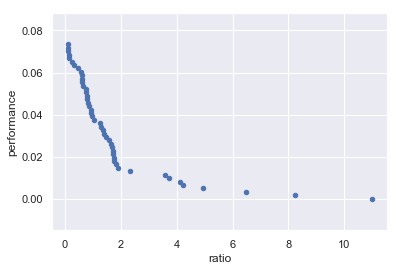

In [5]:
def calculate_performance(_df, _column_name, _reverse=False, _linear=False, _weight=1): 
    
    # remove and filter data
    filtred_array = init_flat_data.select(['company_name', _column_name])
    filtred_array = filtred_array.withColumnRenamed(_column_name, 'ratio')
    filtred_array = filtred_array.na.fill(0)

    # calculate quantile
    filtred_quantile = filtred_array.approxQuantile('ratio', [0.05, 0.5, 0.995], 0)

    # remove outlier data
    query_remove_outlier = '{0} > {1} and {0} < {2}'.format('ratio', filtred_quantile[0], filtred_quantile[2])
    filtred_outlier_array = filtred_array.filter(query_remove_outlier)

    #detect max, min, and count
    max_value = filtred_outlier_array.select('ratio').agg({'ratio': 'max'}).collect()[0][0]
    min_value = filtred_outlier_array.select('ratio').agg({'ratio': 'min'}).collect()[0][0]
    count_values = filtred_outlier_array.count()

    #rank customer by ratio
    ranked_data = filtred_outlier_array  \
        .withColumn("rank", dense_rank().over(Window.orderBy(desc('ratio')) ))

    # calculate performance
    if _linear:

        # calculate the linear droite
        x = [min_value, max_value]
        y = [0, 1] if not _reverse else [1, 0]

        coefficients = np.polyfit(x, y, 1)
        polynomial = np.poly1d(coefficients)

        #define udf method
        calculate_perf_def  = udf(lambda x: float(0) if x is None else float(polynomial(x))   , FloatType())

        ranked_data = init_flat_data  \
            .join(ranked_data, on=['COMPANY_NAME'], how='left')\
            .select(['company_name', 'ratio', 'rank']) \
            .sort(asc('ratio'))  \
            .withColumn('performance', calculate_perf_def('ratio'))

    
    else:
        #define udf method
        format_perf_def  = None
        if not _reverse:
            format_perf_def = udf(lambda x: float(0) if x is None else (count_values - x + 1) / count_values , FloatType())
        else:
            format_perf_def = udf(lambda x: float(0) if x is None else 1- (count_values - x + 1) / count_values , FloatType())

        ranked_data = init_flat_data \
            .join(ranked_data, on=['COMPANY_NAME'], how='left') \
            .select(['company_name', 'ratio', 'rank']) \
            .sort(desc('ratio'))  \
            .withColumn('performance', format_perf_def('rank'))  
    
    
    return ranked_data.withColumn('performance', ranked_data['performance'] * _weight)



ratio_name = 'RATIO_CAPITAL_LEASE_PPE'
_reverse = reversed_proba[ratio_name] 
_linear  = linearity[ratio_name] 
_weight  = weights[ratio_name] 
    
performance = calculate_performance(init_flat_data, ratio_name, _linear=_linear, _reverse=_reverse, _weight=_weight)
performance = performance.sort(asc('company_name'))
performance.toPandas().plot(kind='scatter', x='ratio', y='performance')
 
performance.show(5)
    


In [6]:
prefix_spliter = 'RATIO_'
potential_prefix = 'POTENTIAL_'
global_result = init_flat_data.filter('1=1')
potential_columns = []
# calculate individual perf
for column_name in filter(lambda x: prefix_spliter in x, global_result.columns):
    new_potential_column = column_name.replace(prefix_spliter, potential_prefix) 
    potential_columns.append( new_potential_column )
    
    
    # calculate potential
    _reverse = reversed_proba[column_name] 
    _linear  = linearity[column_name] 
    _weight = weights[column_name]
    
    performance = calculate_performance(global_result, column_name, _reverse=_reverse, _linear=_linear, _weight=_weight)
    performance = performance.select(['company_name', 'performance'])
    performance = performance.withColumnRenamed('performance', new_potential_column)
    
    
    global_result = global_result.join(performance, how='left', on=['company_name'])
    
    

# calculate final potential
global_result = global_result \
    .withColumn('final_potential', sum([global_result[x] for x in potential_columns  ]) )


In [7]:
# calculate forcast nbi
mean_ppe_asset = global_result.select('RATIO_PPE_ASSETS').agg({'RATIO_PPE_ASSETS': 'mean'}).collect()[0][0]
half_mean_ppe_asset = mean_ppe_asset / 2

print('mean : ' , mean_ppe_asset)
print('half mean : ', half_mean_ppe_asset)
print("\n")





def calculate_forcast_nbi(ratio_ppe_asset, total_assets):
    result_part1 = 0
    result_part2 = 0
    result_part3 = 0
    
    beta_1 = 1
    beta_2 = 0.3
    beta_3 = 0.1
    
    interest_rate = 0.00235
    machinery = 0.35
    
    if ratio_ppe_asset > mean_ppe_asset:
        result_part1 = (ratio_ppe_asset - mean_ppe_asset) 
    else:
        result_part1 = 0 
    
     
    
    if ratio_ppe_asset > half_mean_ppe_asset:
        if ratio_ppe_asset > mean_ppe_asset:
            result_part2 =  half_mean_ppe_asset 
        else:
            result_part2 = (ratio_ppe_asset - half_mean_ppe_asset) 
    else:
         result_part2 = 0
            
    if ratio_ppe_asset < half_mean_ppe_asset:
        result_part3 =   ratio_ppe_asset 
    else:
        result_part3 =   half_mean_ppe_asset 
    
     
    
    result_part1 *= beta_1 * machinery * total_assets 
    result_part2 *= beta_2 * machinery * total_assets
    result_part3 *= beta_3 * machinery * total_assets
    
    return result_part1 + result_part2 + result_part3

calculate_forcast_nbi_udh = udf(calculate_forcast_nbi, FloatType())
global_result = global_result \
    .withColumn('forecast_nbi', calculate_forcast_nbi_udh('RATIO_PPE_ASSETS', 'TOTAL_ASSETS'))

#calculate final rank
global_result = global_result.withColumn('final_potential_nbi', global_result['final_potential'] * global_result['forecast_nbi'])


#add rank
global_result = global_result  \
        .withColumn("final_rank", dense_rank().over(Window.orderBy(desc('final_potential_nbi')) ))


#segment all clients
define_segment = lambda x: 'OR' if x < 10 else 'SILVER' if x < 20 else 'BRONZE' if x < 30 else 'NA'
define_segment_def_udf = udf(define_segment, StringType())

global_result = global_result \
    .withColumn('segment_name', define_segment_def_udf('final_rank')) \
    .select(['company_name', 'final_potential', 'forecast_nbi', 'final_potential_nbi', 'final_rank', 'segment_name'])



# add a flag column before save
global_result = global_result.withColumn('product_name', lit('Leasing'))
global_result = global_result.withColumn('state_banker', lit('-'))


#rename column to lwoercase
global_result = global_result \
    .select( [F.col(x).alias(x.lower()) for x in global_result.columns] )


mean :  1.570640129633248
half mean :  0.785320064816624




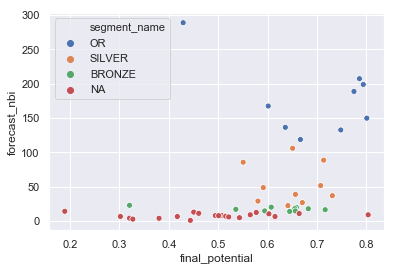

In [8]:
ax = sns.scatterplot(x="final_potential", y="forecast_nbi",hue="segment_name", data=global_result.toPandas())

In [9]:
# show schema
global_result.printSchema()

root
 |-- company_name: string (nullable = true)
 |-- final_potential: double (nullable = true)
 |-- forecast_nbi: float (nullable = true)
 |-- final_potential_nbi: double (nullable = true)
 |-- final_rank: integer (nullable = true)
 |-- segment_name: string (nullable = true)
 |-- product_name: string (nullable = false)
 |-- state_banker: string (nullable = false)



In [10]:
# save result in my postgresql database
mode = "overwrite"
table_name = 'algo_external_data_analysis'
url = "jdbc:postgresql://127.0.0.1:5432/financial_opportunities"
properties = {
    "user": "zouhairhajji",
    "password": '',
    "driver": "org.postgresql.Driver"
}
global_result  \
        .write     \
        .jdbc(url=url, table=table_name, mode=mode, properties=properties)